In [2]:
#Importing relavant libraries
from __future__ import print_function
from PIL import Image

import numpy as np

#Importing VGG16 convolution network
from keras.applications.vgg16 import VGG16
from keras import backend as K
from keras import Model

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

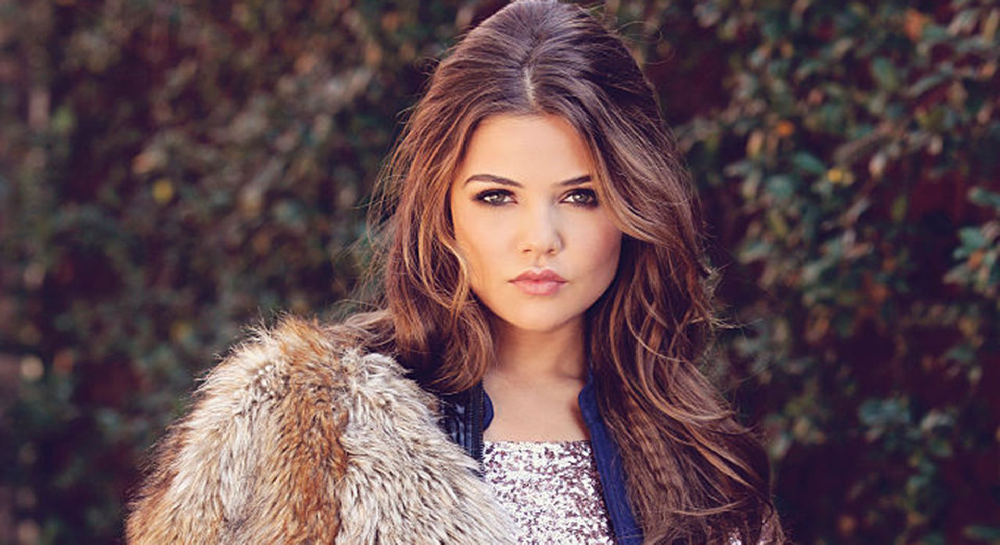

In [3]:
content_image_path = "images/danielle_campbell.jpg"
content_image = Image.open(content_image_path)
content_image = content_image.resize((1000, 545))
content_image

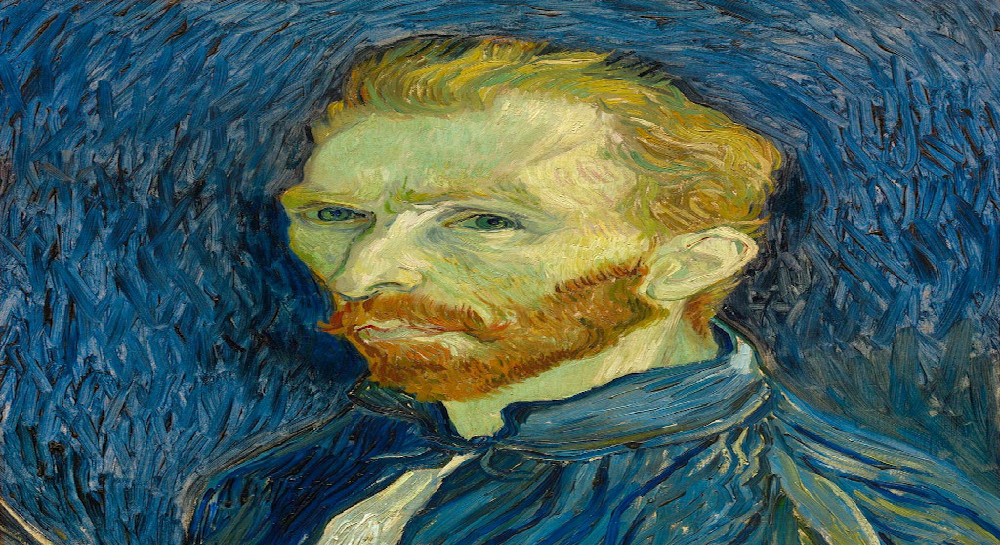

In [4]:
style_image_path = "images/van_gough.jpg"
style_image = Image.open(style_image_path)
style_image = style_image.resize((content_image.size))
style_image

In [5]:
content_array = np.asarray(content_image, dtype = 'float32')
content_array = np.expand_dims(content_array, axis = 0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype = 'float32')
style_array = np.expand_dims(style_array, axis = 0)
print(style_array.shape)

(1, 545, 1000, 3)
(1, 545, 1000, 3)


In [6]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]


In [7]:
content_image = K.variable(content_array)
style_image = K.variable(style_array)

combination_image = K.placeholder(content_array.shape)

input_tensor = K.concatenate([content_image,style_image,combination_image], axis = 0)

In [8]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

In [9]:
layers = dict([(layer.name, layer.output) for layer in model.layers])

In [10]:
content_weight = 0.25
style_weight = 5.0
total_variation_weight = 1.0

In [11]:
loss = K.variable(0.)
width = 1000
height = 545

In [12]:
def content_loss(content,combination):
    return K.sum(K.square(content-combination))

In [13]:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

In [14]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram



In [15]:
def style_loss(style,combination):
    st = gram_matrix(style)
    co = gram_matrix(combination)
    channels = 3
    #w, h = content_image.size
    size = width*height
    return K.sum(K.square(st-co))/(4.*(channels**2)*(size**2))

In [16]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

In [17]:
for layer in feature_layers:
    layer_features = layers[layer]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += style_weight/(len(feature_layers))*style_loss(style_features, combination_features)

In [18]:
def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

loss += total_variation_weight*total_variation_loss(combination_image)

In [19]:
grads = K.gradients(loss,combination_image)

In [20]:
outputs = [loss]
outputs += grads
f_outputs = K.function([combination_image],outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [21]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128

iterations = 10
for i in range(iterations):
    print('Start of iteration', i)
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)

Start of iteration 0
Current loss value: 1.76472e+11
Start of iteration 1
Current loss value: 1.22912e+11
Start of iteration 2
Current loss value: 1.02437e+11
Start of iteration 3
Current loss value: 9.12906e+10
Start of iteration 4
Current loss value: 8.52371e+10
Start of iteration 5
Current loss value: 8.17865e+10
Start of iteration 6
Current loss value: 7.97566e+10
Start of iteration 7
Current loss value: 7.8436e+10
Start of iteration 8
Current loss value: 7.76016e+10
Start of iteration 9
Current loss value: 7.70558e+10


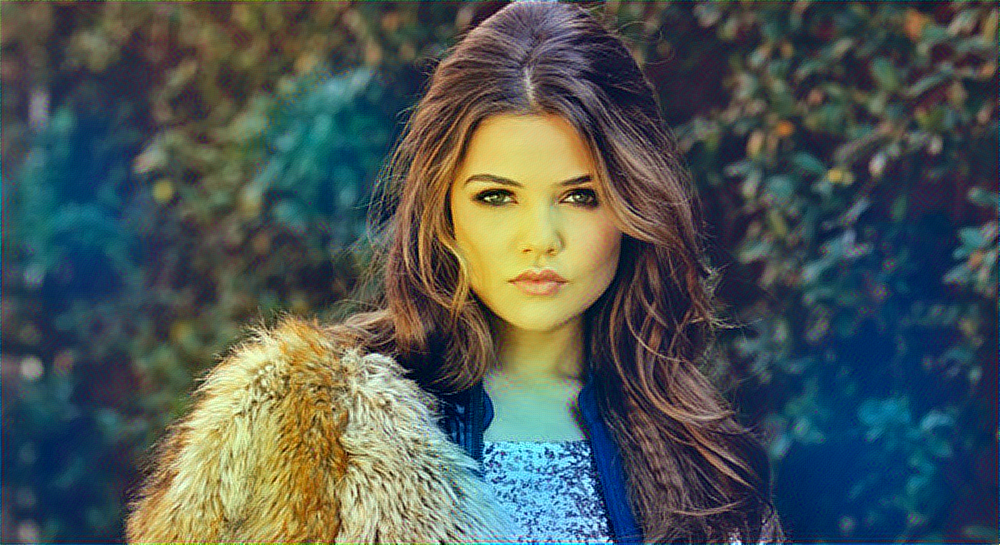

In [22]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

In [ ]:
#